In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
end_date   = dt.datetime.today()
start_date = end_date - dt.timedelta(days=1000)

df_original = yf.download('^NSEI', start=start_date, end = end_date, interval='1d')
df = df_original.copy()

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

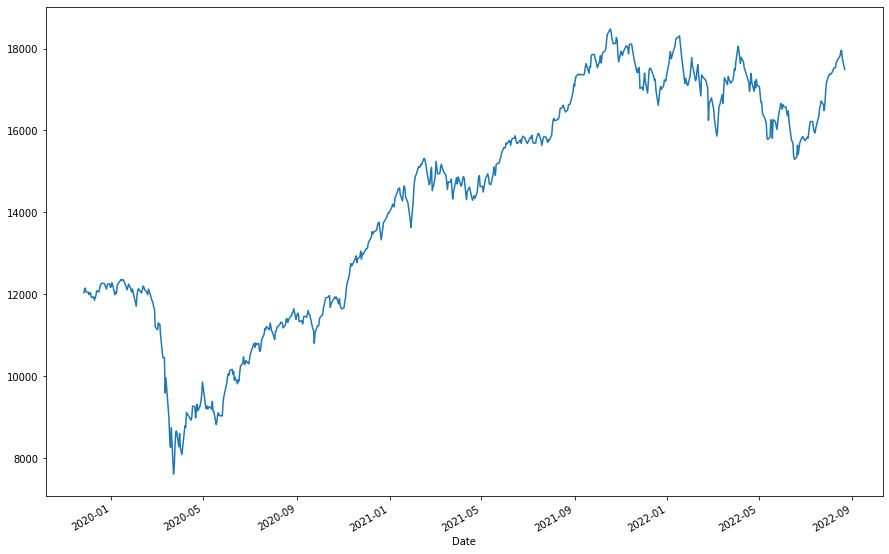

In [3]:
init_notebook_mode(connected = True)
cf.go_offline()
#ploting the daily close price
#df['Adj Close'].iplot()
df['Adj Close'].plot(figsize=(15,10))

<AxesSubplot:xlabel='Date'>

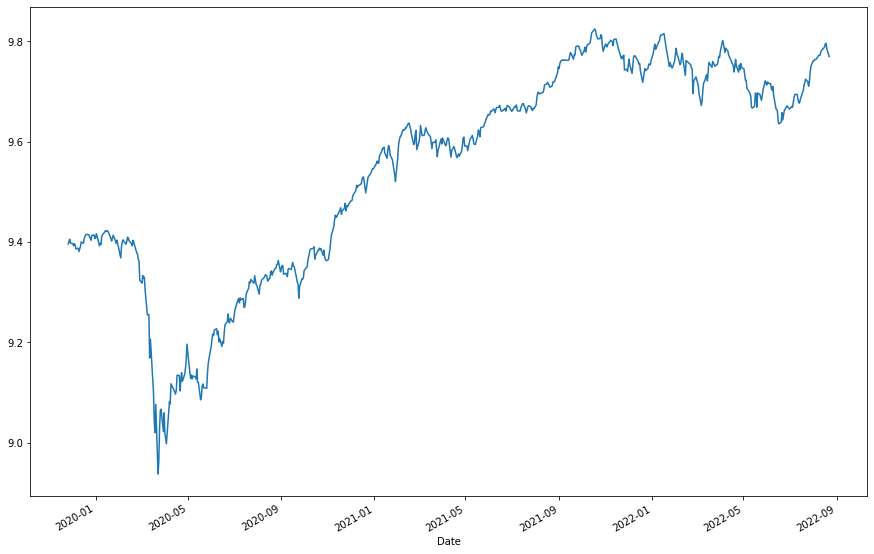

In [4]:
df['log_close'] = np.log(df['Adj Close'])

# to visuvalise the severity of bearish fall
#df['log_close'].iplot()
df['log_close'].plot(figsize=(15,10))

In [5]:
df['log_return'] = (df['log_close'] - df['log_close'].shift())*100
df.dropna(inplace=True)

<AxesSubplot:xlabel='Date'>

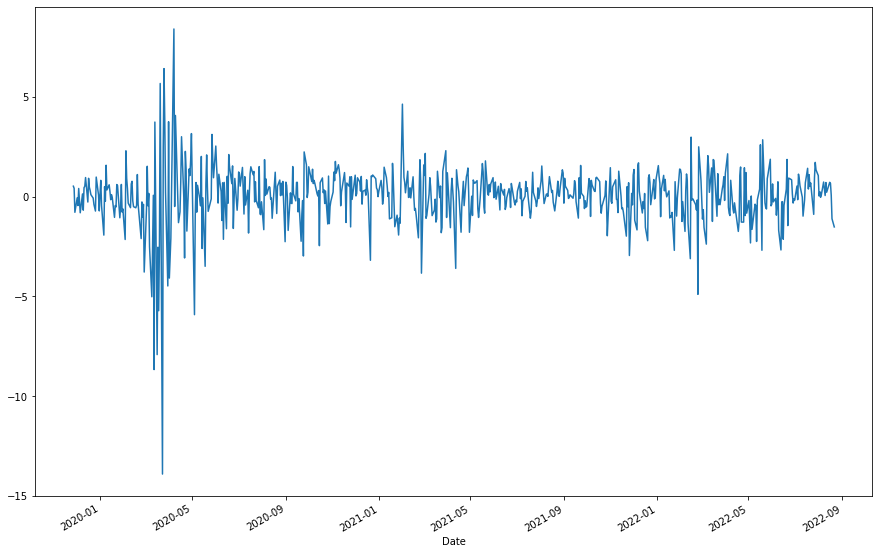

In [6]:
#visualising the daily log return data
#df['log_return'].iplot()
df['log_return'].plot(figsize=(15,10))

In [7]:
from statsmodels.tsa.stattools import adfuller

stationarity_test = adfuller(df['log_return'])
p_val_stationary = stationarity_test[1]
print(f'p-value of the stationary test is {p_val_stationary}\n')

if p_val_stationary<0.05:
    print('Daily log return time series is stationary with 95% confidence')
else:
    print('Time series is not stationary with 95% confidence')

p-value of the stationary test is 2.311148893080666e-11

Daily log return time series is stationary with 95% confidence


In [8]:
# Spliting data into 2 part: Train data and Test Data
split_size = int(len(df)*0.8)
train_df, test_df = df.iloc[:split_size], df.iloc[split_size:]

In [9]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm

# import warning to supress the warning due to datetime index in DataFrame
import warnings
warnings.simplefilter('ignore')

#setting freq to daily 
#if data is not daily data uncomment below lines

train_df = train_df.asfreq('d').dropna()
train_df.dropna(inplace=True)

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Volatility')

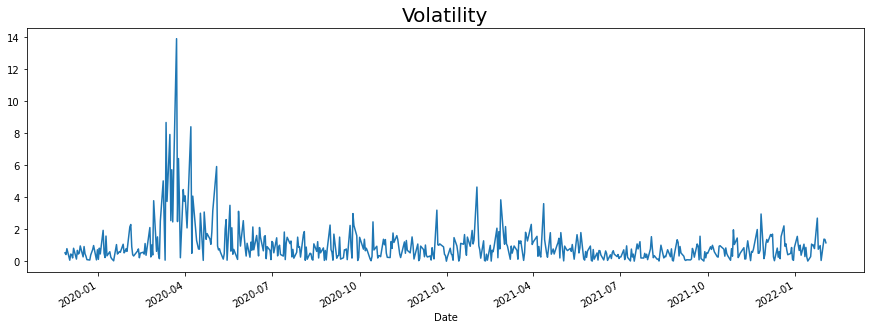

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Log Return')

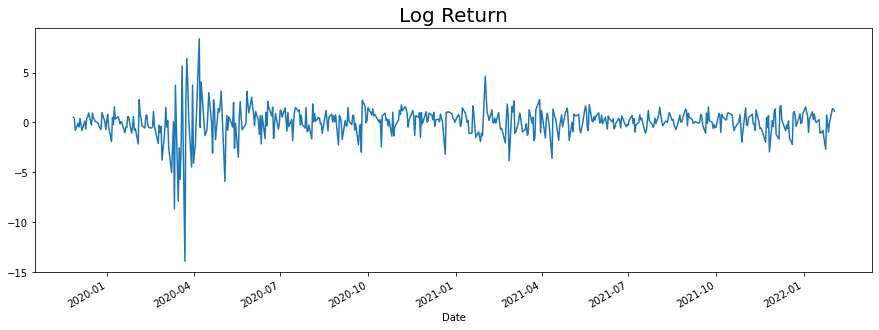

In [10]:
train_df['daily_volatility'] = np.sqrt(np.square(train_df['log_return']))
train_df['daily_volatility'].plot(figsize=(15,5))
plt.title('Volatility',size=20)
plt.show()

train_df['log_return'].plot(figsize=(15,5))
plt.title('Log Return',size=20)
plt.show()


In [11]:
from arch import arch_model

In [12]:
#Below model assumptions
# 1) Mean model: Zero
# 2) Volatility Model = ARCH
# 3) Distribution of time series is Normal/Gaussian distribution

ARCH_model = arch_model(df['log_return'],mean='Zero',vol='ARCH', dist='Normal', p=1)
result_ARCH = ARCH_model.fit(update_freq=10, last_obs=train_df.index[-1])

result_ARCH.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 919.5452980661739
            Iterations: 6
            Function evaluations: 22
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Zero Mean - ARCH Model Results                        
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                       ARCH   Log-Likelihood:               -919.545
Distribution:                  Normal   AIC:                           1843.09
Method:            Maximum Likelihood   BIC:                           1851.68
                                        No. Observations:                  543
Date:                Mon, Aug 22 2022   Df Residuals:                      543
Time:                        22:06:24   Df Model:                            0
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          1.2189      0.238      5.123  3.014e-07 [  0.753,  1.685]
alpha[1]       0.4782      0.136      3.507  4.532e-04 [  0.211,  0.745]
========================================================================

Covariance estimator: robust
"""

In [13]:
#Below model assumptions
# 1) Mean model: Zero
# 2) Volatility Model = GARCH(1,1)
# 3) Distribution of time series is Normal/Gaussian distribution

GARCH_model = arch_model(df['log_return'],mean='Zero',vol='GARCH', dist='Normal', p=1, q=1)
result_GARCH = GARCH_model.fit(update_freq=10, last_obs=train_df.index[-1])

result_GARCH.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 833.8473059776819
            Iterations: 9
            Function evaluations: 43
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:               -833.847
Distribution:                  Normal   AIC:                           1673.69
Method:            Maximum Likelihood   BIC:                           1686.59
                                        No. Observations:                  543
Date:                Mon, Aug 22 2022   Df Residuals:                      543
Time:                        22:06:24   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0415  2.120e-02      1.959  5.010e-02 [-1.780e-05,8.310e-02]
alpha[1]       0.1341  4.439e-02      3.022  2.509e-03    [4.715e-02,  0.221]
beta[1]        0.8473  3.896e-02     21.748 7.286e-105      [  0.771,  0.924]
=============================================================================

Covariance estimator: robust
"""

In [14]:
#Below model assumptions
# 1) Mean model: Some constant value 
# 2) Volatility Model = GARCH(1,1)
# 3) Distribution of time series is T-distribution

GARCH_model = arch_model(df['log_return'],mean='Constant',vol='GARCH', dist='t', p=1, q=1, rescale=True)
result_GARCH = GARCH_model.fit(update_freq=10, last_obs=train_df.index[-1])

result_GARCH.summary()

Iteration:     10,   Func. Count:     72,   Neg. LLF: 811.7595543424412
Optimization terminated successfully    (Exit mode 0)
            Current function value: 811.7595383210664
            Iterations: 12
            Function evaluations: 84
            Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                   log_return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -811.760
Distribution:      Standardized Student's t   AIC:                           1633.52
Method:                  Maximum Likelihood   BIC:                           1655.00
                                              No. Observations:                  543
Date:                      Mon, Aug 22 2022   Df Residuals:                      542
Time:                              22:06:24   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1550  3.985e-02      3.890  1.001e-04 [7.692e-02,  0.233]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0378  1.733e-02      2.183  2.903e-02 [3.867e-03,7.180e-02]
alpha[1]       0.1057  3.130e-02      3.378  7.309e-04   [4.438e-02,  0.167]
beta[1]        0.8743  2.874e-02     30.426 2.526e-203     [  0.818,  0.931]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.3150      1.032      5.149  2.618e-07 [  3.292,  7.338]
========================================================================

Covariance estimator: robust
"""

In [ ]:
# Based on above GARCH(1,1) with t-distribution model, FOrcating the Volatility of Time Series
forecasting_GARCH = result_GARCH.forecast(horizon=1,align='origin')
forecasted_var = forecasting_GARCH.residual_variance[test_df.index[0]:test_df.index[-1]]

test_df['forecasted_volatility'] = np.sqrt(forecasted_vol)
test_df['daily_volatility'] = np.sqrt(np.square(test_df['log_return']))
test_df[['daily_volatility','forecasted_volatility']].plot(figsize=(15,5))

plt.show()